<a href="https://colab.research.google.com/github/Seungwon-hub/ESAA/blob/main/ESAA_YB_kaggle%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Exploration Notebook

In [78]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None # default='warn'

In [79]:
from google.colab import drive

!mkdir -p /content/MyDrive/ESAA/kaggle # Create the directory in Colab's local filesystem

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
order_products_train_df = pd.read_csv("order_products__train.csv")
order_products_prior_df = pd.read_csv("order_products__prior.csv")
orders_df = pd.read_csv("orders.csv")
products_df = pd.read_csv("products.csv")
aisles_df = pd.read_csv("aisles.csv")
departments_df = pd.read_csv("departments.csv")

In [81]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1.0,prior,1.0,2.0,8.0,NaN
1,2398795,1.0,prior,2.0,3.0,7.0,15.0
2,473747,1.0,prior,3.0,3.0,12.0,21.0
3,2254736,1.0,prior,4.0,4.0,7.0,29.0
4,431534,1.0,prior,5.0,4.0,15.0,28.0


In [82]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1.0,1.0
1,2,28985,2.0,1.0
2,2,9327,3.0,0.0
3,2,45918,4.0,1.0
4,2,30035,5.0,0.0


In [83]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


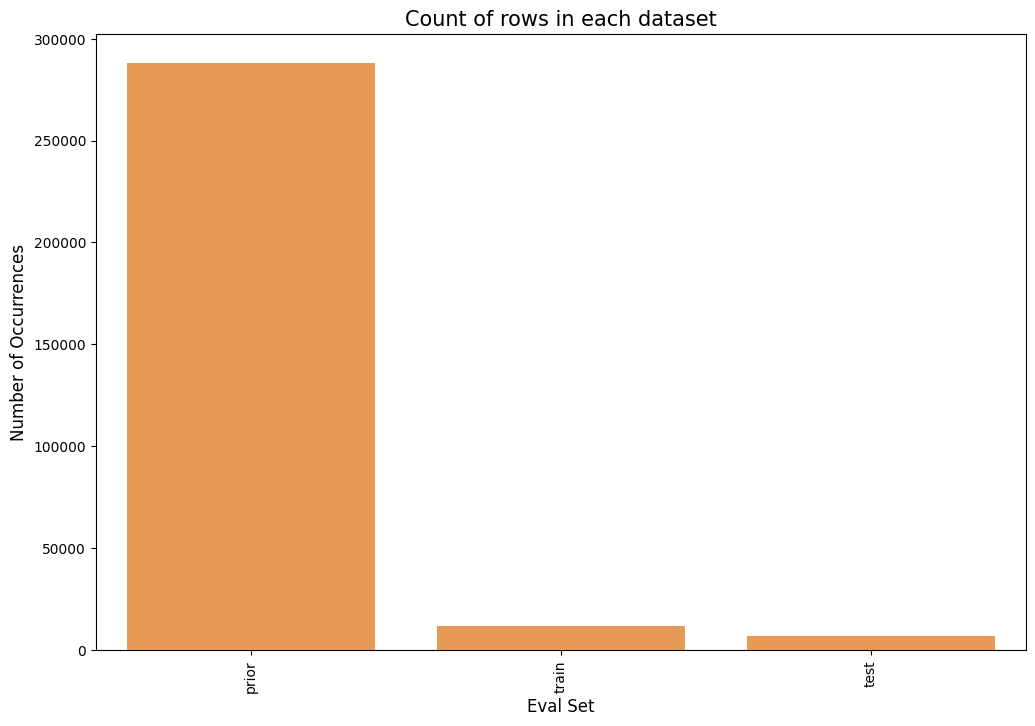

In [84]:
cnt_srs = orders_df.eval_set.value_counts()

plt.figure(figsize=(12, 8))
sns.barplot(x=cnt_srs.index.tolist(), y=cnt_srs.values.tolist(), alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval Set', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical') # x축 레이블이 겹치지 않도록 조정
plt.show()

In [85]:
def get_unique_count(x):
  return len(np.unique(x))

cnt_srs = orders_df.groupby("eval_set")["user_id"].aggregate(get_unique_count)
cnt_srs

,user_id
eval_set,
prior,18527
test,6674
train,11852


 There are 18527 customers in total. Out of which, the last purchase of 11852 customers are given as train set and we need to predict for the rest 6674 customers.

<ipython-input-86-c1e40bc8dcac>:1: FutureWarning: The provided callable <function max at 0x7bb98cb5a160> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()


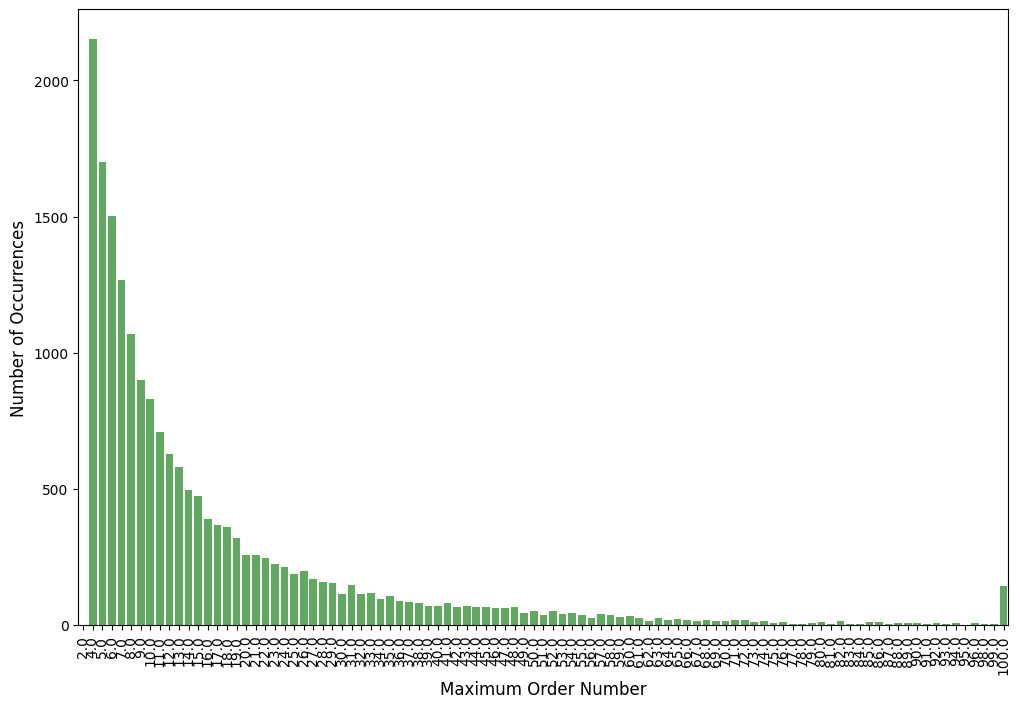

In [86]:
cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum Order Number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

- aggregate(): 그룹별로 여러 개의 함수를 적용할 때 사용
- There are no orders less than 4 and is max capped at 100 as given in the data page.

#### Let's see how the ordering habit changes with day of week

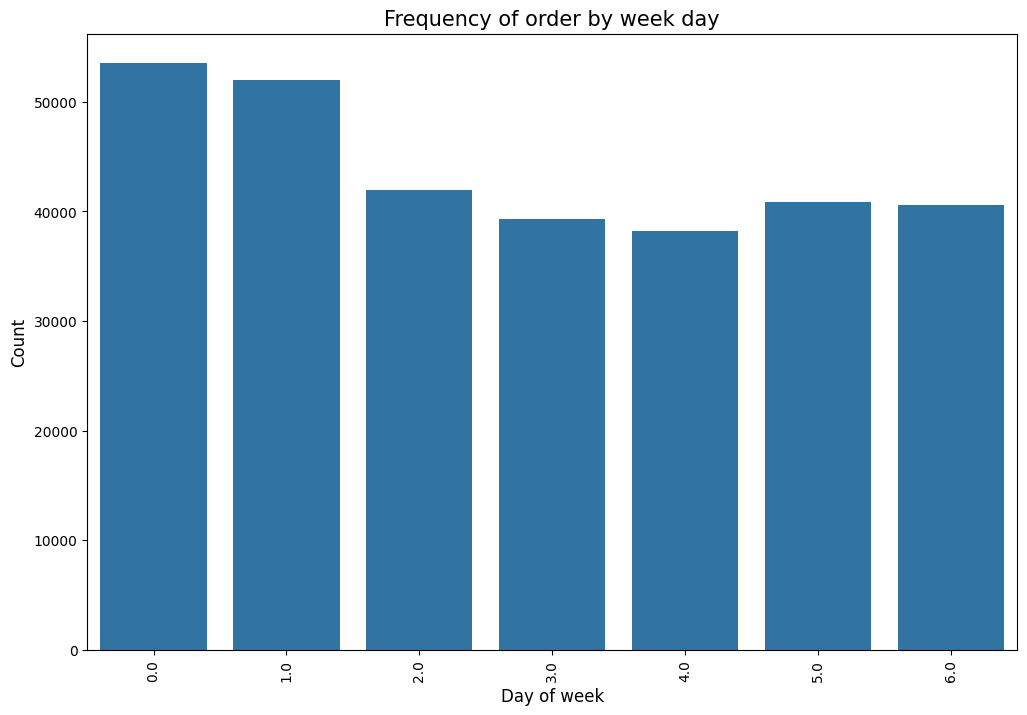

In [87]:
plt.figure(figsize=(12,8))
sns.countplot(x='order_dow', data=orders_df, color=color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

Seems like 0 and 1 is Saturday and Sunday when the orders are high and low during Wednesday.

#### We shall see how the distribution is with respect to time of the day.**굵은 텍스트**

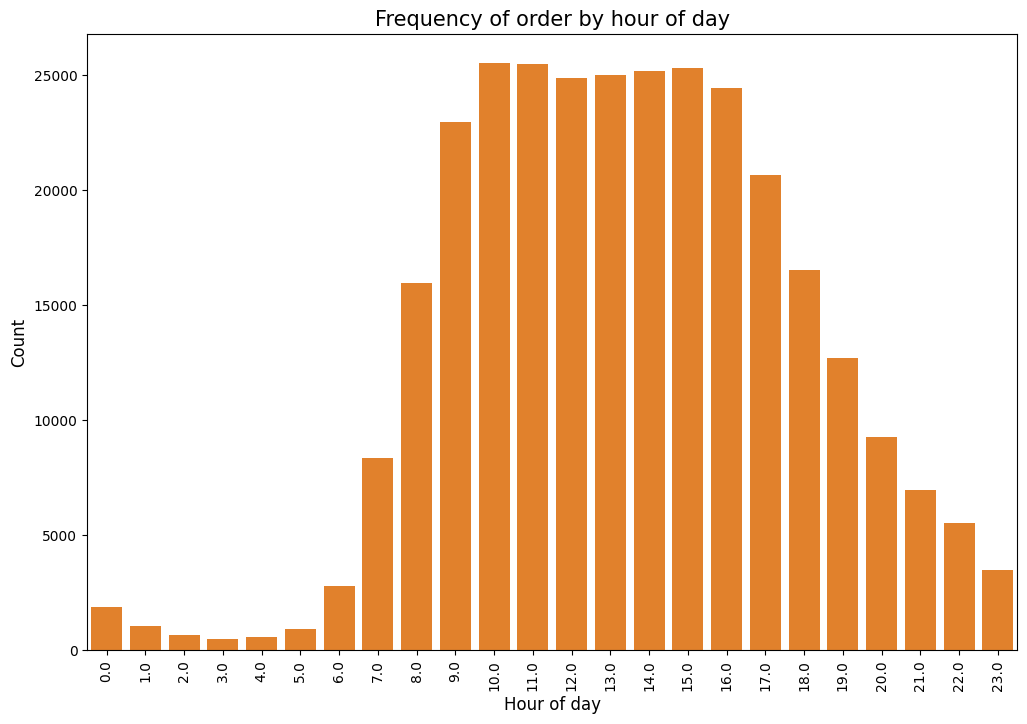

In [88]:
plt.figure(figsize=(12,8))
sns.countplot(x='order_hour_of_day', data=orders_df, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

Majority of the orders are made during day time.

#### Let us combine the day of week and hour of day to see the distribution.

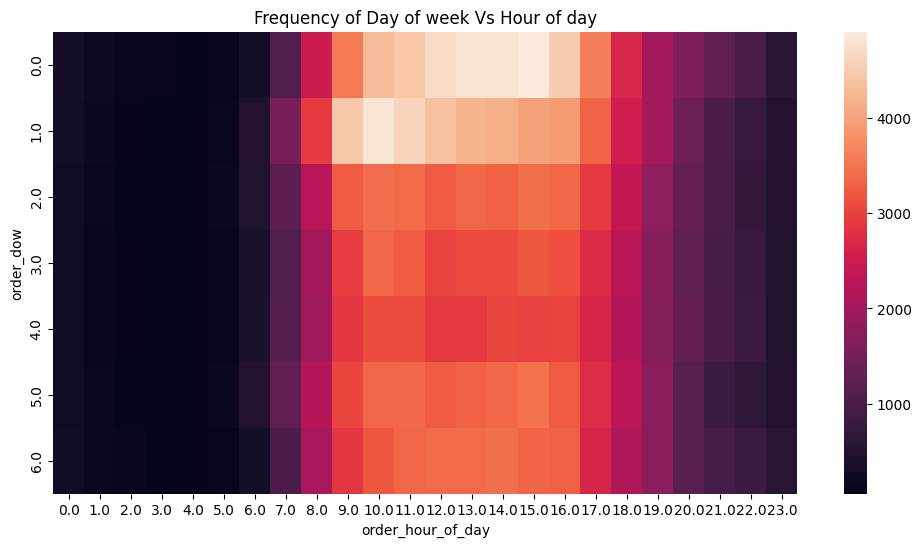

In [89]:
grouped_df = orders_df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot(index="order_dow",columns="order_hour_of_day", values="order_number")


plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

Seems Satuday evenings and Sunday mornings are the prime time for orders.

#### Let us check the time interval between the orders.

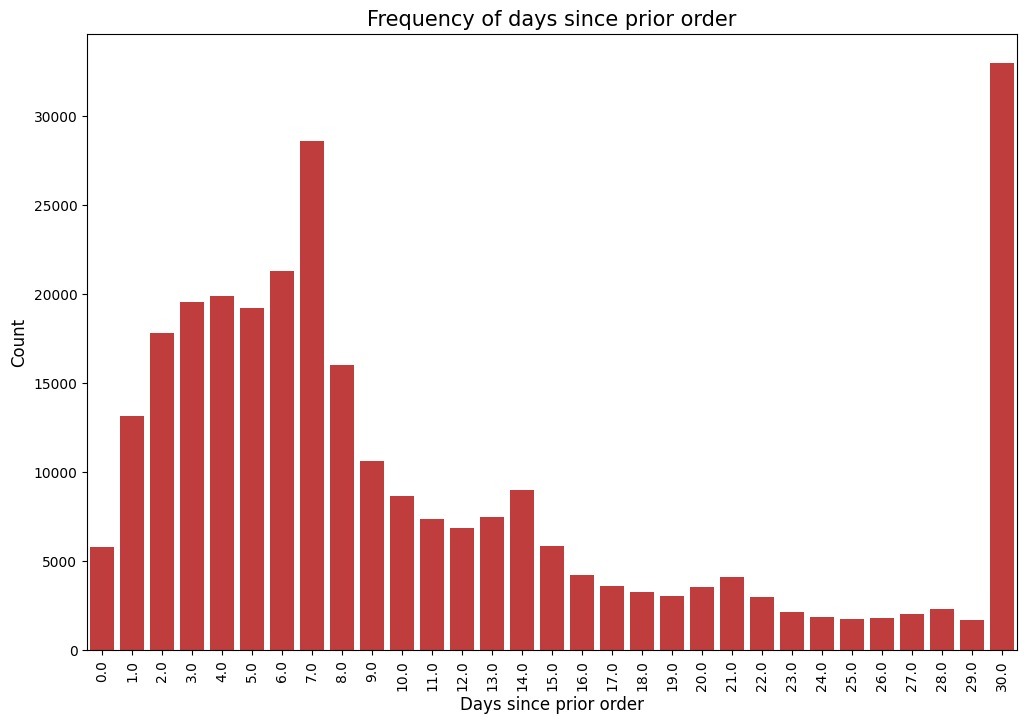

In [90]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders_df, color=color[3])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of days since prior order", fontsize=15)
plt.show()

Looks like customer order once in every week or once in a month. We could see smaller peaks at 14, 21 and 28 days.

#### Let's check out the re-order percentage in prior set and train set.

In [91]:
# percentage of re-orders in prior set #
order_products_prior_df.reordered.sum()/order_products_prior_df.shape[0]

0.589850527697344

In [92]:
# percentage of re-orders in train set #
order_products_train_df.reordered.sum() / order_products_train_df.shape[0]

0.5985944127509629

On an average, about 59% of the products in an order are re-ordered products.

### No re-ordered products:

Now that we have seen 59% of the products are re-ordered, there will also be situations when none of the products are re-ordered.

In [93]:
grouped_df = order_products_prior_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()

grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1

grouped_df.reordered.value_counts() / grouped_df.shape[0]

<ipython-input-93-ce3b0f832bf1>:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1


,count
reordered,
1.0,0.879717
0.0,0.120283


In [94]:
grouped_df = order_products_train_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()

grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1

grouped_df.reordered.value_counts() / grouped_df.shape[0]

<ipython-input-94-6b4acf0979fc>:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1


,count
reordered,
1,0.93444
0,0.06556


About 12% of the orders in prior set has no re-ordered items while in the train set it is 6.5%

#### Let's see the number of products bought in each order.

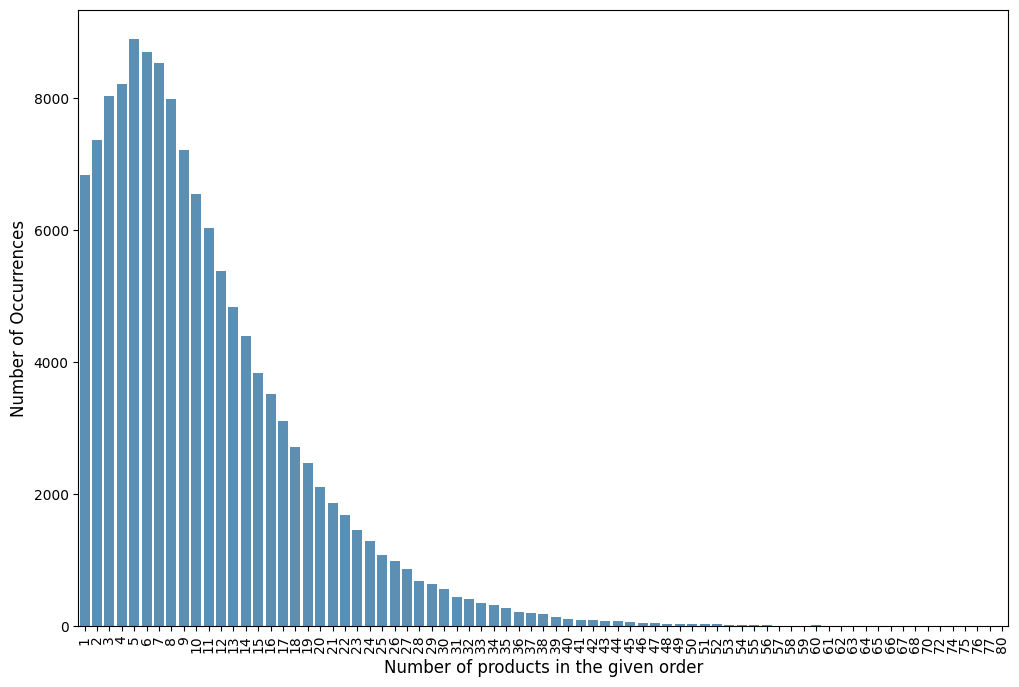

In [95]:
grouped_df = order_products_train_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

A right tailed distribution with the maximum value at 5.

#### Let's look at the other three files as well.

In [96]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [97]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [98]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [99]:
order_products_prior_df = pd.merge(order_products_prior_df, products_df, on='product_id', how='left')

order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on="aisle_id", how='left')

order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')

order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1.0,1.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2.0,1.0,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3.0,0.0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4.0,1.0,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5.0,0.0,Natural Sweetener,17,13,baking ingredients,pantry


- pd.merge(): 두 개의 dataframe을 병합하는 함수
- pd.merge(left_df, right_df, on="공통된 열", how="조인 방식")

In [100]:
cnt_srs = order_products_prior_df['product_name'].value_counts().reset_index().head(20)

cnt_srs.columns = ['product_name', 'frequency_count']

cnt_srs

,product_name,frequency_count
0,Banana,30834
1,Bag of Organic Bananas,24646
2,Organic Strawberries,17137
3,Organic Baby Spinach,15714
4,Organic Hass Avocado,13804
5,Organic Avocado,11374
6,Large Lemon,9890
7,Strawberries,9318
8,Limes,9117
9,Organic Whole Milk,8855


- reset_index(): 인덱스 리셋하고 기존 인덱스를 새로운 열로 변환하는 함수

Most of them are organic products. Majority of them are fruits.

#### Let's look at the important aisles.

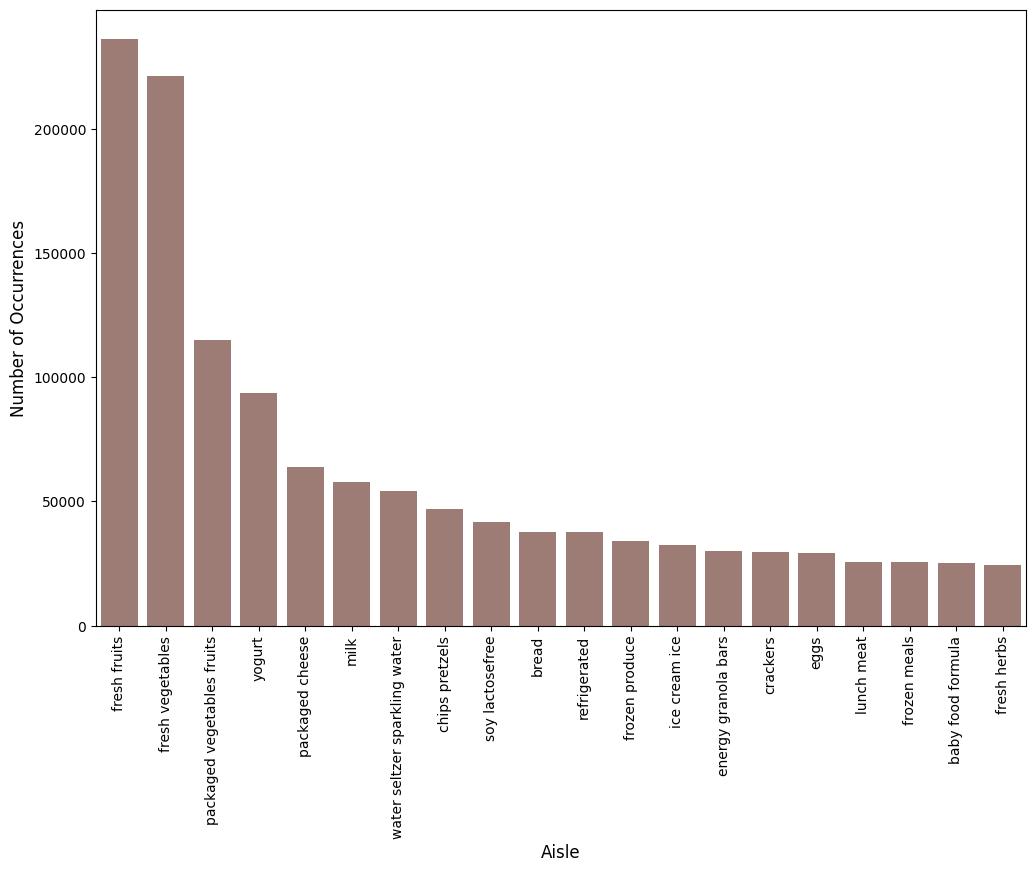

In [103]:
cnt_srs = order_products_prior_df['aisle'].value_counts().head(20)

plt.figure(figsize=(12,8))

sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color=color[5])

plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

The top two aisles are fresh fruits and fresh vegetables.

### Department Distribution

#### Let's check the department wise distribution.

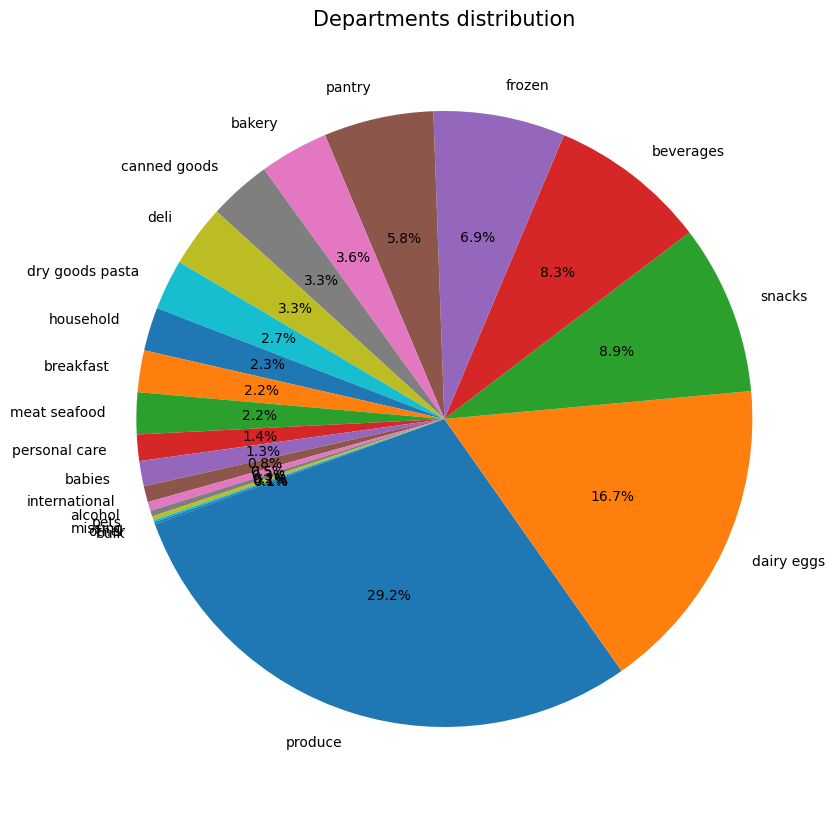

In [104]:
plt.figure(figsize=(10,10))
temp_series = order_products_prior_df['department'].value_counts()

labels=(np.array(temp_series.index))
sizes=(np.array((temp_series / temp_series.sum())*100))

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=200)

plt.title("Departments distribution", fontsize=15)

plt.show()


- value_counts(): 각 고유값의 개수를 세는 함수, 데이터 분포를 파악하거나 특정 칼럼의 빈도 분석할 때 유용

Produce is the largest department.

#### Let's check the reordered percentage of each department.

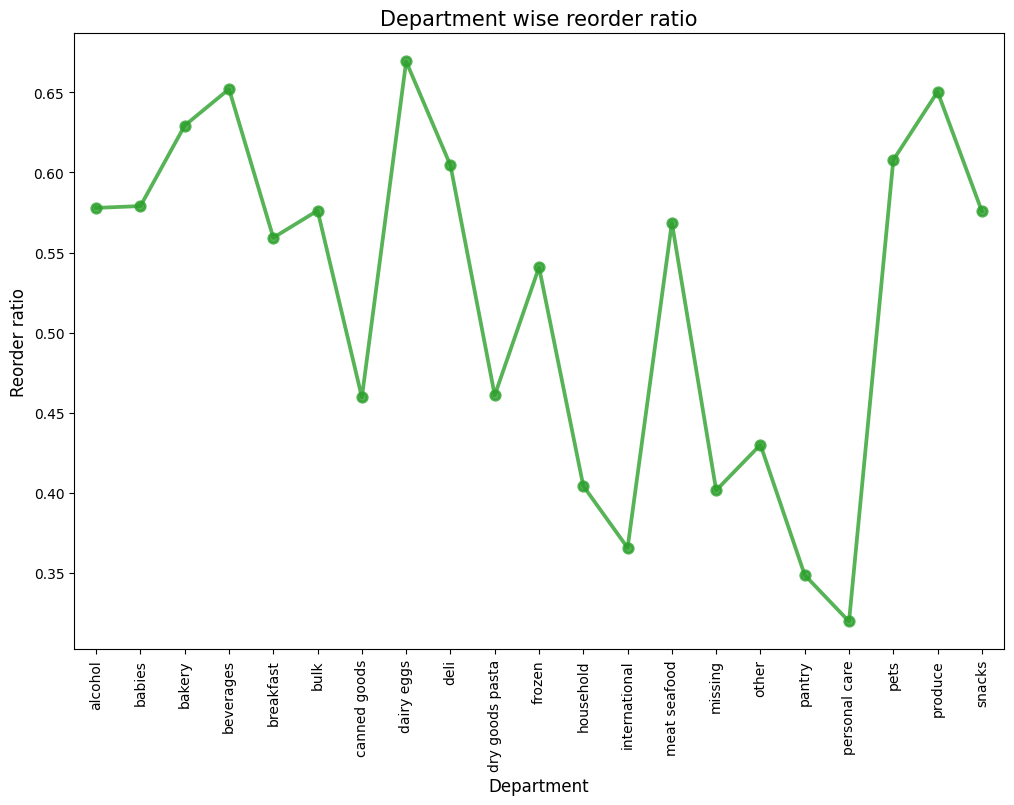

In [106]:
grouped_df = order_products_prior_df.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(x=grouped_df['department'].values, y=grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

- aggregate(): 여러 개의 집계 함수를 적용할 수 있도록 해주는 함수, groupby()와 함께 사용하여 그룹별 연산 수행에 유용

Personal care has lowest reorder ratio and dairy eggs have highest reorder ratio.

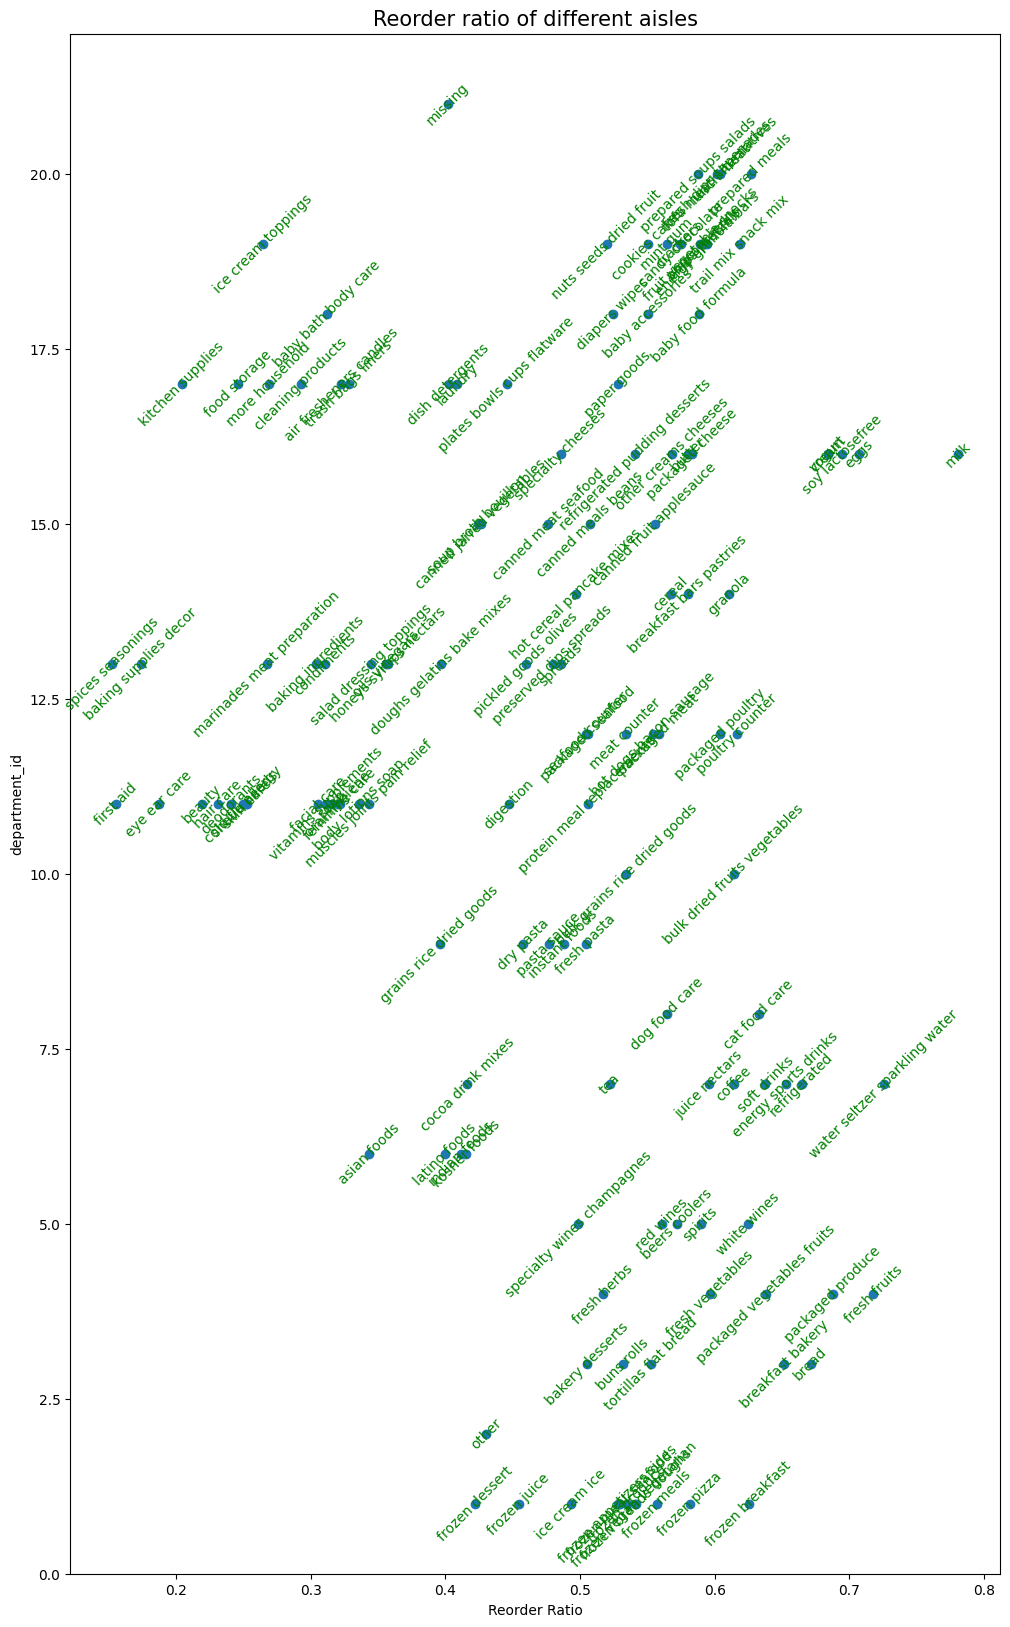

In [107]:
grouped_df = order_products_prior_df.groupby(["department_id", "aisle"])["reordered"].aggregate("mean").reset_index()

fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values)

for i, txt in enumerate(grouped_df.aisle.values):
  ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]), rotation=45, ha='center', va='center', color='green')

plt.xlabel('Reorder Ratio')
plt.ylabel('department_id')
plt.title("Reorder ratio of different aisles", fontsize=15)
plt.show()

- ax.annotate(): 그래프 위 특정 위치에 주석을 추가하는 함수

### Add to Cart - Reorder ratio

#### Let's explore the relationship between how order of adding the product to the cart affects the reorder ratio.

<ipython-input-109-023cdd417774>:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  order_products_prior_df["add_to_cart_order_mod"].iloc[order_products_prior_df["add_to_cart_order_mod"]>70]=70


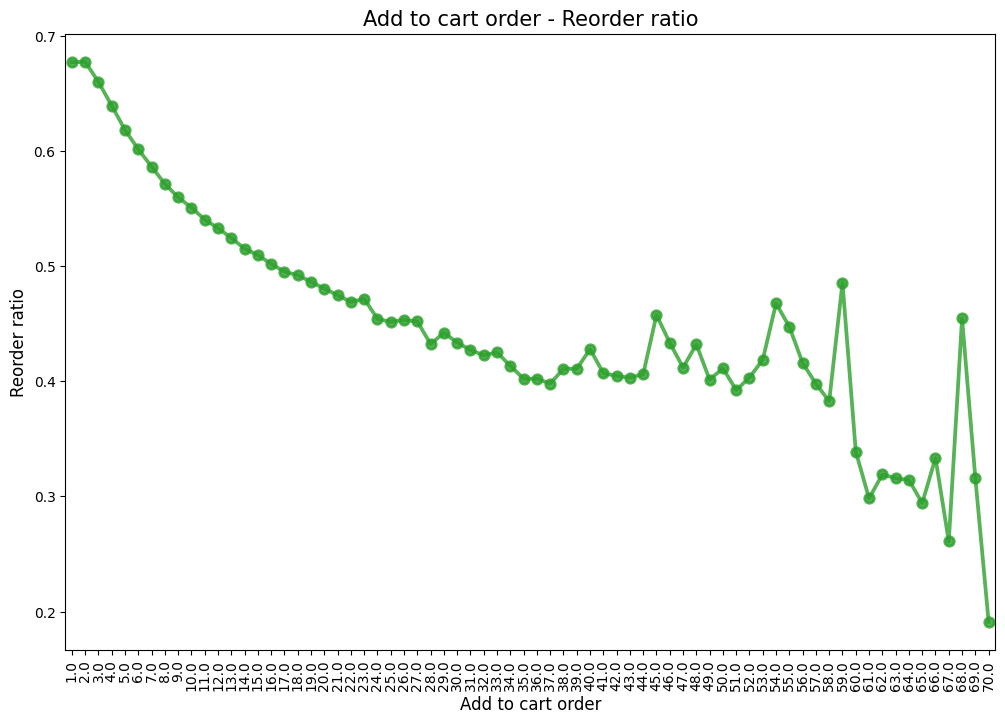

In [109]:
order_products_prior_df["add_to_cart_order_mod"] = order_products_prior_df["add_to_cart_order"].copy()

order_products_prior_df["add_to_cart_order_mod"].iloc[order_products_prior_df["add_to_cart_order_mod"]>70]=70

grouped_df = order_products_prior_df.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(x=grouped_df['add_to_cart_order_mod'], y=grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title('Add to cart order - Reorder ratio', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

- copy(): dataframe or series에서 복사본 만드는 것. 원본 데이터 변경 방지

Looks like the products that are added to the cart initially are more likely to be reordered again compared to the ones added later. This makes sense to me as well since we tend to first order all the products we used to buy frequently and then look out for the new products available.

#### Reorder ratio by time based variables

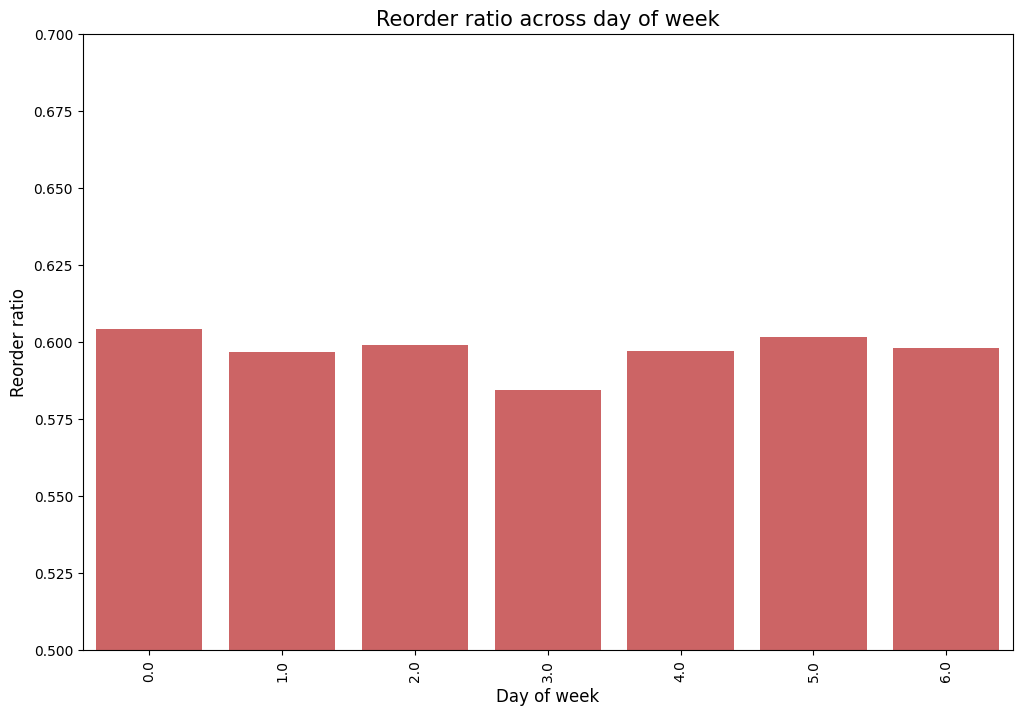

In [110]:
order_products_train_df = pd.merge(order_products_train_df, orders_df, on='order_id', how='left')

grouped_df = order_products_train_df.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(x=grouped_df['order_dow'].values, y=grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

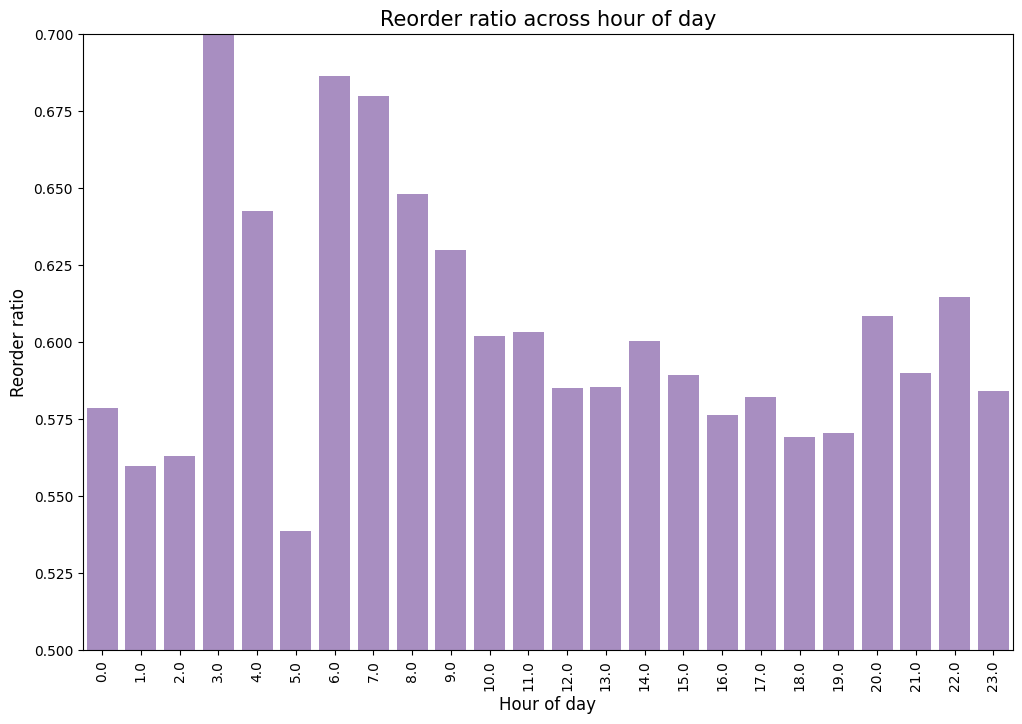

In [111]:
grouped_df = order_products_train_df.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(x=grouped_df['order_hour_of_day'].values, y=grouped_df['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5,0.7)
plt.show()

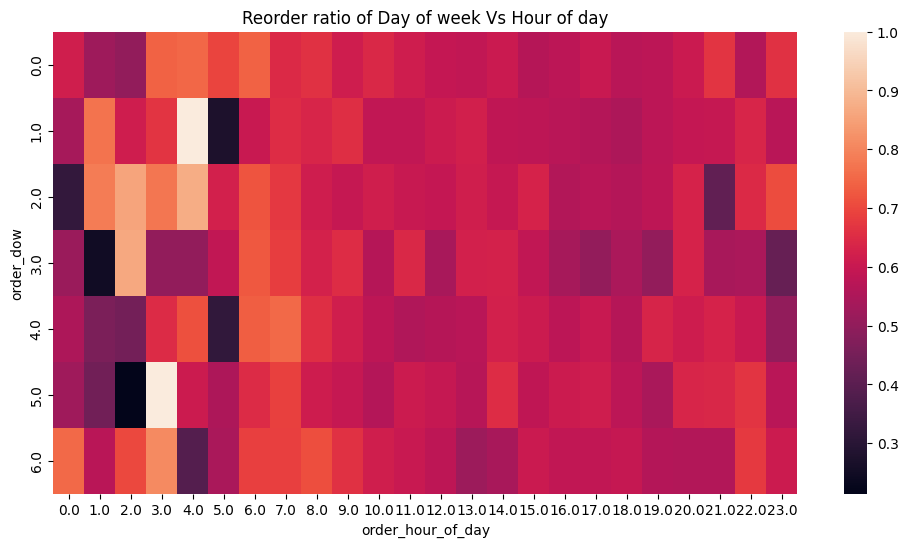

In [114]:
grouped_df = order_products_train_df.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot(index='order_dow', columns='order_hour_of_day', values='reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()

Looks like reorder ratios are quite high during the early mornings compared to later half of the day.